## Exploration_SSAC 03 카메라 스티커앱 만들기

프로젝트 :: 고양이 수염 스티커 만들기  
준비물 :: 다양한 각도, 다양한 크기의 얼굴 이미지 / 고양이 수염이 될 스티커 이미지

* 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근의 기술  
* 얼굴이 포함된 이미지, 스티커로 만들 이미지 준비  
* openCV 내장 함수 익혀서 활용 (imread, imshow, addWeighted ...)
* dlib 라이브러리에 대하여 탐구

##### Project Process

1) 얼굴이 인식될 수 있을 사진  
(물체가 함께 한 사진 속에 있거나, 신체의 다른 부위와 겹쳤을 때 오는 오류 Point Check)  

2) 얼굴을 찾는 **HOG Detector 정의 + Bounding Box와 얼굴 선/부위 별 위치(점)으로 찍히는 landmark/alignment 탐지**

3) landmark/bounding box를 중심으로 **좌표를 지정**하여 스티커 위치 조정

4) Bounding / dot 제거하고 사진 스티커 필터 작업 마무리

##### 필요한 모듈 import

이미지 프로젝트 관련 라이브러리 :: openCV, matplotlib, dlib  
이미지 채널을 RGB 순으로 사용하지만, openCV의 경우 BGR을 사용하기 때문에,  
사용하기 전, **RGB채널 형태로 변경해 주는 과정이 중요!**

In [1]:
import cv2 # 이미지 처리를 위한
import matplotlib.pyplot as plt # 중간 중간 이미지 시각화를 위한
import dlib # 얼굴 인식을 위한
import numpy as np # 행렬 연산을 위한
import os # 경로를 설정하여 이미지 로드를 위한

##### 다양한 각도의 이미지를 구글에서 다운받아 저장했고, 
##### 스티커 이미지도 다운받아 camera_sticker/images 디렉토리에 저장
* 손이 얼굴에 겹쳐 있거나, 물건이 함께 포함되어 있을 때 LMS node 상에서는 인식이 안되었던 점을 감안하여 골고루 이미지 선택

### 1) 일반적인 사진 + 일반적인 스티커

##### 준비한 이미지 Load

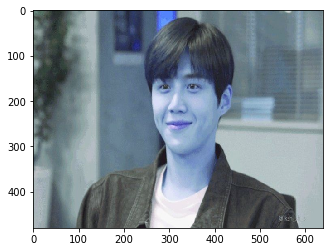

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.jpg'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 480)) # 객체를 너무 줄이게 되면 인식을 못할 수도 있기 때문에 사진의 특성에 따라 조금씩 변경 필요
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

위의 결과물에서 볼 수 있듯이, OpenCV의 imread 함수(함수의 특징이 아닌, OpenCV 라이브러리 특성) 는 이미지를 BGR (기존 RGB) 형태로 출력하게 된다. 이를 원본 색감을 살리기 위해 **convert color == cvtColor** 함수와 **COLOR_BGR2RGB** 함수를 활용하여 다시 출력 단계 거치자!

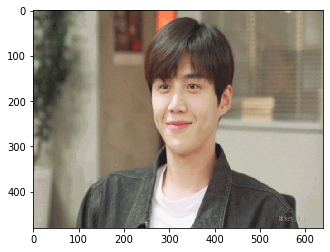

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()

##### dlib 활용 (hog detector , bounding box 추출)

HOG (Histogram of Oriented Gradient) Feature  
* 영상에서 Gradient를 계산하고 계산 된 값을 이용하여 Local Histogram을 생성한다. 이렇게 생성된 Histogram을 이여 붙여 1차원 vector를 생성한다.  

SVM classifier

* HOG를 사용하여 Object Recognition을 하기 위해 필요한 것은 Supervised learning을 기반으로 한 어떤 Recognition으로의 Descriptors이다. SVM(Support vector machine) 분류기는 binary classifier이며, optimal hyperplane을 찾아야 한다.

참고) https://hayunjong83.tistory.com/38

In [4]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
print("🌫🛸")

🌫🛸


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)
print("🌫🛸")
print(dlib_rects)

🌫🛸
rectangles[[(221, 118) (407, 304)]]


* 위에서 dlib_rects의 좌표가 나와야 bounding box가 제대로 추출되었다는 의미이다.

In [ ]:
# bounding box 추출

In [6]:
?cv2.rectangle
'''
rectangle(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) -> img
.   @brief Draws a simple, thick, or filled up-right rectangle.
.   
.   The function cv::rectangle draws a rectangle outline or a filled rectangle whose two opposite corners
.   are pt1 and pt2.
.   
.   @param img Image.
.   @param pt1 Vertex of the rectangle.
.   @param pt2 Vertex of the rectangle opposite to pt1 .
.   @param color Rectangle color or brightness (grayscale image).
.   @param thickness Thickness of lines that make up the rectangle. Negative values, like #FILLED,
.   mean that the function has to draw a filled rectangle.
.   @param lineType Type of the line. See #LineTypes
.   @param shift Number of fractional bits in the point coordinates.

* bounding box 의 꼭지점을 left, top, right, bottom을 선정해 주고, 
* 각각의 parameter에 맞게 지정해 줌

'''

rectangles[[(221, 118) (407, 304)]]


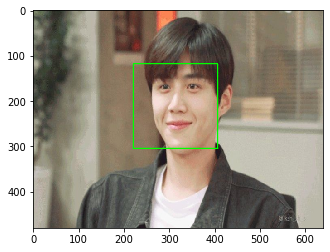

In [7]:
# 위에서 detector_hog를 통해 bounding box가 추출되었다면, 각 꼭지점을 지정해줌
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    # cv2.rectangle(img, 꼭지점1, 꼭지점1과 대각선 반대에 있는 꼭지점2, bbox 컬러, bbox 라인 두께, 그 라인 타입)
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


##### Dlib landmark localization

In [ ]:
# landmark 추출

In [8]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [10]:
?landmark_predictor

In [9]:
# bounding box로 추출한 얼굴에서 68개의 이목구비 위치 포인트 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


68


In [66]:
list_landmarks

[[(262, 177),
  (261, 196),
  (263, 216),
  (266, 236),
  (271, 257),
  (281, 275),
  (293, 293),
  (306, 307),
  (324, 312),
  (344, 309),
  (364, 299),
  (382, 283),
  (396, 265),
  (405, 245),
  (409, 223),
  (410, 201),
  (410, 180),
  (267, 159),
  (273, 148),
  (285, 143),
  (298, 143),
  (311, 147),
  (330, 148),
  (344, 142),
  (360, 141),
  (375, 146),
  (386, 156),
  (318, 167),
  (317, 182),
  (315, 197),
  (313, 212),
  (302, 224),
  (309, 227),
  (315, 229),
  (323, 228),
  (332, 225),
  (280, 171),
  (286, 165),
  (295, 165),
  (303, 172),
  (295, 174),
  (286, 174),
  (340, 172),
  (348, 165),
  (358, 165),
  (366, 170),
  (358, 173),
  (349, 173),
  (294, 251),
  (301, 246),
  (309, 244),
  (315, 245),
  (323, 243),
  (336, 245),
  (350, 249),
  (337, 258),
  (325, 262),
  (317, 264),
  (309, 263),
  (302, 258),
  (299, 251),
  (309, 251),
  (316, 252),
  (324, 251),
  (345, 250),
  (325, 253),
  (317, 254),
  (310, 253)]]

In [74]:
# 얼굴 부위별 위치의 점에 해당하는 사진 속 좌표 68개
points.parts()

points[(262, 177), (261, 196), (263, 216), (266, 236), (271, 257), (281, 275), (293, 293), (306, 307), (324, 312), (344, 309), (364, 299), (382, 283), (396, 265), (405, 245), (409, 223), (410, 201), (410, 180), (267, 159), (273, 148), (285, 143), (298, 143), (311, 147), (330, 148), (344, 142), (360, 141), (375, 146), (386, 156), (318, 167), (317, 182), (315, 197), (313, 212), (302, 224), (309, 227), (315, 229), (323, 228), (332, 225), (280, 171), (286, 165), (295, 165), (303, 172), (295, 174), (286, 174), (340, 172), (348, 165), (358, 165), (366, 170), (358, 173), (349, 173), (294, 251), (301, 246), (309, 244), (315, 245), (323, 243), (336, 245), (350, 249), (337, 258), (325, 262), (317, 264), (309, 263), (302, 258), (299, 251), (309, 251), (316, 252), (324, 251), (345, 250), (325, 253), (317, 254), (310, 253)]

In [75]:
?cv2.circle
'''
circle(img, center, radius, color[, thickness[, lineType[, shift]]]) -> img
.   @brief Draws a circle.
.   
.   The function cv::circle draws a simple or filled circle with a given center and radius.
.   @param img Image where the circle is drawn.
.   @param center Center of the circle.
.   @param radius Radius of the circle.
.   @param color Circle color.
.   @param thickness Thickness of the circle outline, if positive. Negative values, like #FILLED,
.   mean that a filled circle is to be drawn.
'''

* 사진 속 랜드마크 68개 list 안에서 각각의 landmark를 추출할 것이고,  
* enumerate 함수로 각 번호표를 붙여서 하나의 point를 추출할 것이고,  
* 이를 cv2.circle 함수로 노랑색 점으로 찍을 것이다

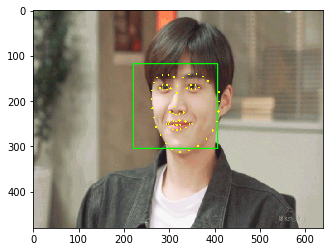

In [11]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow == (0, 255, 255)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

##### 스티커 이미지 적용

In [12]:
# index[30] 위치인 얼굴의 중심 코 포인트를 중심으로 좌표 설정
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] # + dlib_rect.width() //2
    w = dlib_rect.width() 
    h = dlib_rect.width() 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(313, 212)
(x,y) : (313,212)
(w,h) : (187,187)


In [13]:
landmark[30], landmark[30][1]

((313, 212), 212)

In [ ]:
# 스티커 이미지 로드

In [14]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 바운딩 박스 크기만큼 resize
print (img_sticker.shape)

(187, 187, 3)


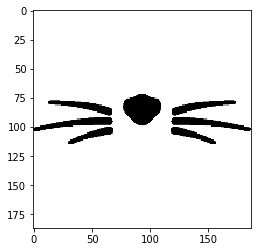

In [15]:
plt.imshow(img_sticker)

In [16]:
img_sticker.shape

(187, 187, 3)

In [17]:
print(x, y)
print(w, h)

313 212
187 187


In [18]:
refined_x = x - w //2   # left
refined_y = y - h  //2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (220,119)


OpenCV 데이터는 numpy ndarray 형태의 데이터를 사용한다. 따라서 음수에 대한 예외 처리를 해주어야 하는데, 위에서 (x, y) 값에서 둘 다 양수가 나왔기 때문에 예외처리를 안해도 된다.

In [ ]:
# img_sticker = img_sticker[-refined_y:]
# print (img_sticker.shape)

# refined_y = 0
# print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [22]:
img_sticker.shape

(187, 187, 3)

In [19]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


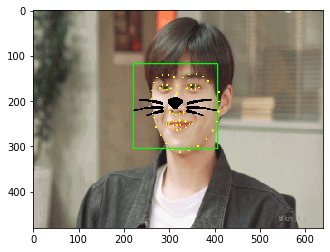

In [20]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# bounding box 와 landmark 제거하여 마무리

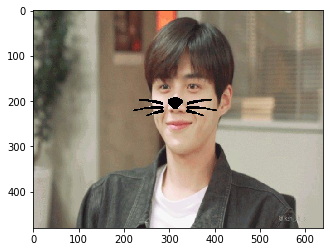

In [21]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 2) 물체가 있는 사진 + 스티커

첫 시도에서 bounding box를 못 잡아내는 오류가 있었다. 이유를 못 찾고 있었는데, 원본 사진 비율과 최대한 비슷하게 resize를 해주었더니 바로 잡아내었다.

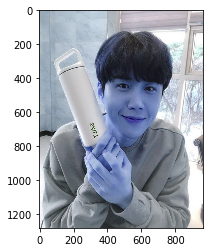

In [189]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (960, 1280)) # 객체를 너무 줄이게 되면 인식을 못할 수도 있기 때문에 사진의 특성에 따라 조금씩 변경 필요
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

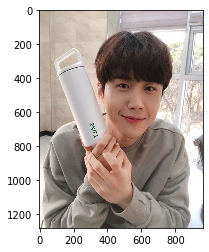

In [190]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()

In [191]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)
print(dlib_rects)

rectangles[[(384, 384) (705, 705)], [(270, 641) (378, 749)]]


**↑↑ 옆의 사물까지 객체로 인식하여 bbox를 2개를 추출해 낸 것 같다**

rectangles[[(384, 384) (705, 705)], [(270, 641) (378, 749)]]


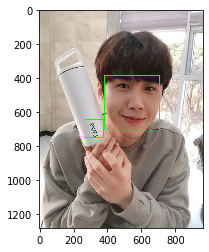

In [192]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


**객체가 2개가 추출되었을 때, landmark 추출 과정에서 고민**

##### dlib landmark localization

In [193]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [194]:
# bounding box로 추출한 얼굴에서 68개의 이목구비 위치 포인트 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


In [195]:
# 두 바운딩박스에 대한 좌표는 넣어져 있고
len(list_landmarks)

2

* 기존 방법에서 landmark가 다중으로 잡히지 않아, 새로운 코드로 시도했으나, 하나의 bbox landmark도 추출하지 못해 실패

In [160]:
# model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(model_path)
# faces = detector(img_show_rgb)

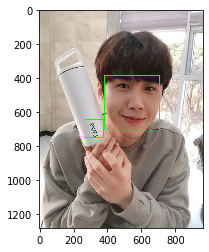

In [161]:
# for face in faces:
#     x1 = face.left()
#     y1 = face.top()
#     x2 = face.right()
#     y2 = face.bottom()
#     cv2.rectangle(img_show, (x1, y1), (x2, y2), (0, 255, 0), 3)
#     landmarks = predictor(img_show_rgb, face)
    
#     for n in range(0, 68):
#         x = landmarks.part(n).x
#         y = landmarks.part(n).y
#         cv2.circle(img_show, (x,y), 4, (0, 0, 255), -1)
# plt.imshow(img_show_rgb)
# plt.show()

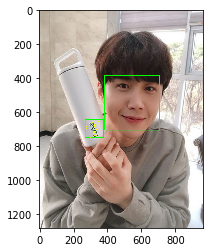

In [196]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow == (0, 255, 255)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3) 손에 겹친 얼굴 이미지 + 스티커

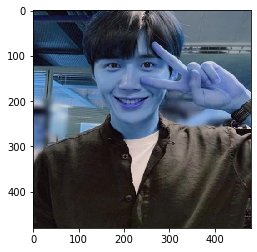

In [85]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/99772B4E5DECA77706.jpg'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (480, 480)) # 객체를 너무 줄이게 되면 인식을 못할 수도 있기 때문에 사진의 특성에 따라 조금씩 변경 필요
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

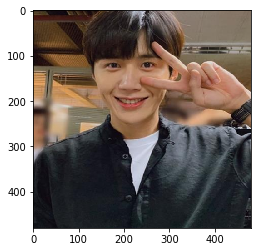

In [86]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()

In [87]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)
print(dlib_rects)

rectangles[[(132, 81) (287, 236)]]


rectangles[[(132, 81) (287, 236)]]


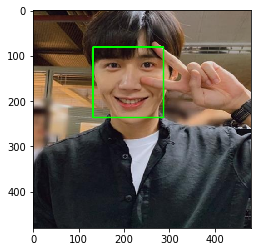

In [88]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


##### dlib landmaark localization

In [89]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [90]:
# bounding box로 추출한 얼굴에서 68개의 이목구비 위치 포인트 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


68


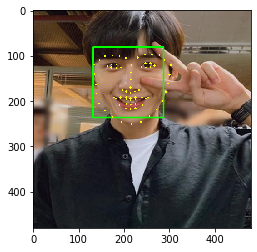

In [91]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow == (0, 255, 255)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

##### 스티커 이미지 적용

In [92]:
# index[30] 위치인 얼굴의 중심 코 포인트를 중심으로 좌표 설정
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] # + dlib_rect.width() //2
    w = dlib_rect.width() 
    h = dlib_rect.width() 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(214, 170)
(x,y) : (214,170)
(w,h) : (156,156)


In [93]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 바운딩 박스 크기만큼 resize
print (img_sticker.shape)

(156, 156, 3)


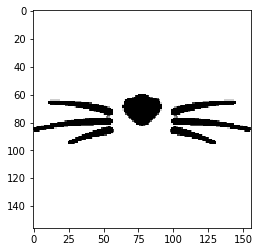

In [94]:
plt.imshow(img_sticker)

In [95]:
img_sticker.shape

(156, 156, 3)

In [96]:
refined_x = x - w //2   # left
refined_y = y - h  //2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (136,92)


In [97]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


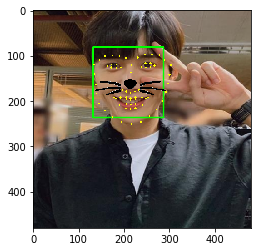

In [98]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

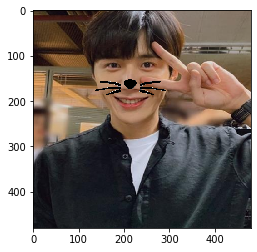

In [99]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 4) 측면 이미지 + 스티커

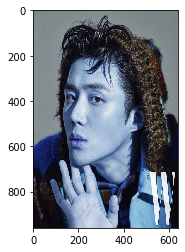

In [173]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/1VDWOXPCZ2_1.jpg'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 960)) # 객체를 너무 줄이게 되면 인식을 못할 수도 있기 때문에 사진의 특성에 따라 조금씩 변경 필요
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

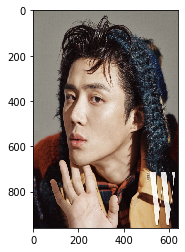

In [174]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()

In [175]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)
print(dlib_rects)

rectangles[[(33, 247) (418, 632)]]


rectangles[[(33, 247) (418, 632)]]


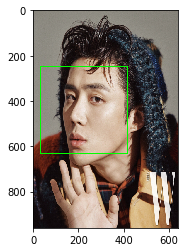

In [176]:
# 위에서 detector_hog를 통해 bounding box가 추출되었다면, 각 꼭지점을 지정해줌
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    # cv2.rectangle(img, 꼭지점1, 꼭지점1과 대각선 반대에 있는 꼭지점2, bbox 컬러, bbox 라인 두께, 그 라인 타입)
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


In [177]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [178]:
# bounding box로 추출한 얼굴에서 68개의 이목구비 위치 포인트 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


68


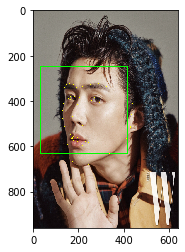

In [179]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow == (0, 255, 255)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [180]:
# index[30] 위치인 얼굴의 중심 코 포인트를 중심으로 좌표 설정
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] # + dlib_rect.width() //2
    w = dlib_rect.width() 
    h = dlib_rect.width() 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(173, 468)
(x,y) : (173,468)
(w,h) : (386,386)


In [181]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 바운딩 박스 크기만큼 resize
print (img_sticker.shape)

(386, 386, 3)


In [182]:
img_sticker.shape

(386, 386, 3)

In [183]:
print(x, y)
print(w, h)

173 468
386 386


In [184]:
refined_x = x - w //2   # left
refined_y = y - h //2   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (-20,275)


* 위에서 x값이 음수가 나왔기 때문에, 예외처리를 해주어야 함

In [185]:
img_sticker = img_sticker[-refined_x:]
print (img_sticker.shape)

refined_x = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(366, 386, 3)
(x,y) : (0,275)


In [186]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


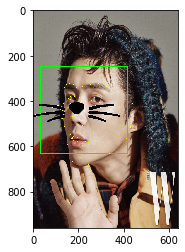

In [187]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

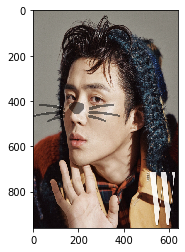

In [188]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## Result of Project

'카메라 스티커 앱 만들기' 프로젝트에서는 **image handling + bounding box + face landmark + visulization** 과정을 거쳤기 때문에,  
* Numpy  
* OpenCV  
* dlib  

라이브러리가 사용되었다.  

각 라이브러리의 주요 함수를 활용하여 프로젝트를 진행하였으며,  
OpenCV 만의 특성인 이미지 채널이 BGR인 것을 유의하여야 한다.  
또한, 각 단계별로 새로운 변수에 할당한 다양한 특성의 이미지 (bgr, rgb, show 등)을 헷갈리지 않고 활용하는 것이 중요했다.  

다음으로는, dlib 라이브러리의 bounding box 추출 및 face landmark 추출이 중요하다.  
각 내장함수의 파라미터 순서 및 특성을 인지하여 활용한다면, HOG 알고리즘을 적용하여 추출하는 과정이 심플하다.  

sticker_area에서 스티커 위치 좌표에 대하여 이해도가 있어야 하는 것이 특징이다.

프로젝트에서 결국 얼굴을 인식하여, bounding box를 추출하고, 그 안에 68개의 landmark를 추출해야 하기 때문에, 카메라와 객체 간의 거리와 각도는 중요하게 작용하는 것 같다.  
(하지만 위에서 작은 객체와 얼굴을 동시에 찾아내었을 때, 바운딩 박스 크기가 굉장히 작았음에도 불구하고 찾아낸 것을 보면 어느 정도의 거리는 적용 가능한 수준인 것 같다.)  

이러한 스티커 앱을 구성할 때는 다양한 모듈과 과정들이 디바이스 안에 들어가기 위해 경량화 과정에서 속도가 조금 느려지거나, 디바이스 발열이 발생하는 것을 직접 경험한 적이 있다.   

직접 프로젝트를 진행해 보니, 다양한 각도의 얼굴 이미지에서 정확도 보다는 실행 속도 및 경량화 퀄리티가 더 중요하게 작용할 것 같단 생각이 든다.

## Good

다양한 라이브러리 활용 및 응용  
정면, 측면 이미지 적용  
이미지를 활용하여 여러가지 기능을 적용해 본 것이 신기했다.

## Difficulties / Challenges

* 두 개 이상의 bounding box의 landmark 추출  
* '코' 위치의 인덱스가 아닌 다른 좌표 중심의 스티커 위치 적용  
* 스티커 자연스럽게 변형 및 얼굴 기울기에 따른 기울기 적용  
* OpenCV에서 제공하는 cv2.CascadeClassifier 를 활용하여 얼굴 인식 프로젝트